# Transfer Learning - vgg16

- This notebook explores transfer learning using the vgg16 model, where the feature extraction layers are kept frozen using the default weights and only the classifier is changed and retrained.

In [18]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime

# Add project root to sys.path if it does not exist
project_root = Path().resolve().parents[0]
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.data.custom_dataset import CustomDataset
from utils.utils import create_logger

In [ ]:
model_variant = "vgg16"
timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [ ]:
logging_config_path = project_root / "conf" / "logger_conf.yml"
logs_dir = project_root / "logs"
logs_dir.mkdir(parents=True, exist_ok=True)
log_filename = project_root / "logs" / f"trnfl_{model_variant}_{timestamp}.log"

In [ ]:
# Initialize logger
logger = create_logger(str(logging_config_path), str(log_filename))

In [ ]:
# Log to confirm setup
logger.info(f"Logging initialized. Log file: {log_filename}")

In [2]:
# Define augmentations to be carried out
train_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # transforms.RandomAffine(degrees=(20, 70), translate=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
train_dir = project_root / "data" / "train"

In [4]:
# Load the train dataset
train_data = ImageFolder(root=str(train_dir))

# Extract labels
labels = [train_data.targets[idx] for idx in range(len(train_data))]

# Get class mapping
class_mapping = {idx: class_name for idx, class_name in enumerate(train_data.classes)}

In [ ]:
# Stratified split into train and val sets
train_indices, val_indices = train_test_split(
    range(len(train_data)), 
    test_size=0.2, 
    stratify=labels, 
    random_state=42
)

In [5]:
# Define train and validation datasets with separate transforms
train_dataset = CustomDataset(train_data, train_indices, transform=train_transformers)
val_dataset = CustomDataset(train_data, val_indices, transform=val_transformers)

In [6]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
# Load pre-trained model, vgg16
model = models.vgg16(weights='DEFAULT')

In [8]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
# Modify final classification layer
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(train_data.classes))

In [ ]:
logger.info(model)

In [ ]:
len(train_data.classes)

In [10]:
# Freeze feature extractor (convolutional layers)
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
# Check for MPS support
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS (Metal Performance Shaders)
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Fallback to CUDA or CPU

# Move model to the selected device
model = model.to(device)
logger.info(f"Using device: {device}")

Using device: mps


In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop + eval on val
epochs = 10

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')

for epoch in range(epochs):
    # Training 
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Predictions for training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Step the learning rate scheduler
    scheduler.step()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    # Val
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Predictions for val accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print metrics 
    logger.info(f"Epoch {epoch+1}/{epochs}")
    logger.info(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Correct Predictions: {correct_train}/{total_train}")
    logger.info(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Correct Predictions: {correct_val}/{total_val}")

Epoch 1/10
Train Loss: 5.0050, Train Accuracy: 2.69%, Correct Predictions: 175/6515
Val Loss: 4.2619, Val Accuracy: 8.23%, Correct Predictions: 134/1629
Epoch 2/10
Train Loss: 4.0516, Train Accuracy: 10.38%, Correct Predictions: 676/6515
Val Loss: 3.5468, Val Accuracy: 16.27%, Correct Predictions: 265/1629
Epoch 3/10
Train Loss: 3.4252, Train Accuracy: 19.11%, Correct Predictions: 1245/6515
Val Loss: 3.1635, Val Accuracy: 23.57%, Correct Predictions: 384/1629
Epoch 4/10
Train Loss: 2.9549, Train Accuracy: 26.77%, Correct Predictions: 1744/6515
Val Loss: 2.9270, Val Accuracy: 27.38%, Correct Predictions: 446/1629
Epoch 5/10
Train Loss: 2.5470, Train Accuracy: 35.29%, Correct Predictions: 2299/6515
Val Loss: 2.8304, Val Accuracy: 29.71%, Correct Predictions: 484/1629
Epoch 6/10
Train Loss: 2.2681, Train Accuracy: 40.95%, Correct Predictions: 2668/6515
Val Loss: 2.7361, Val Accuracy: 29.77%, Correct Predictions: 485/1629
Epoch 7/10
Train Loss: 2.0196, Train Accuracy: 46.92%, Correct Predi

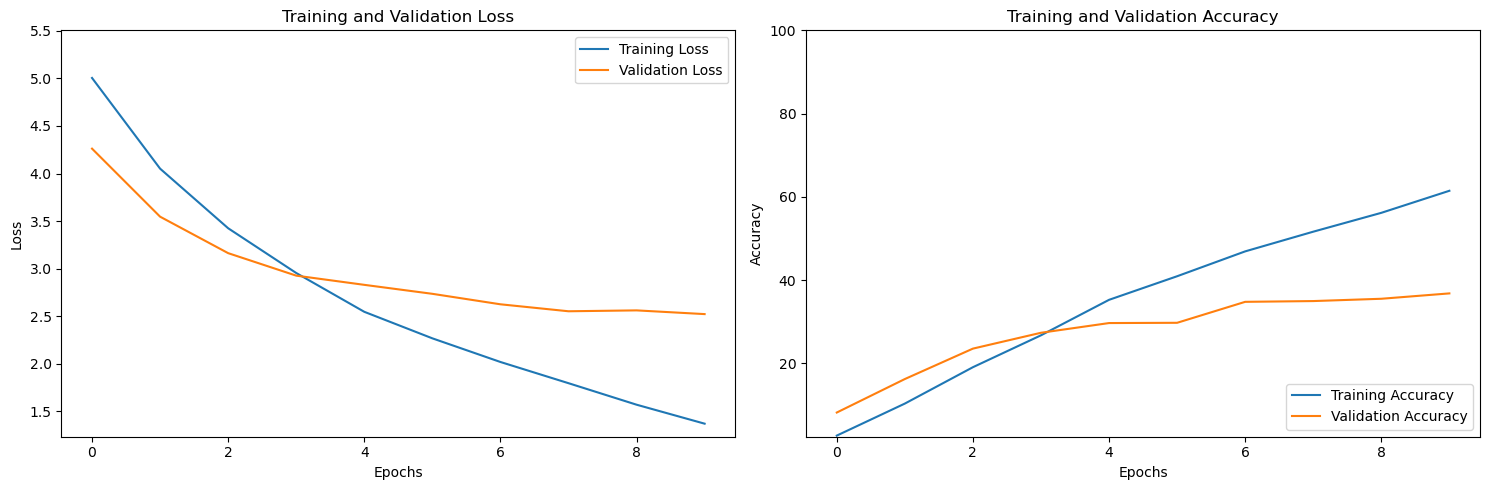

In [13]:
plt.figure(figsize=(15, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim([min(min(train_losses), min(val_losses)) * 0.9, max(max(train_losses), max(val_losses)) * 1.1])
plt.title('Training and Validation Loss')

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim([min(min(train_accuracies), min(val_accuracies)) * 0.9, 100])
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
test_dir = project_root / "data" / "test"

In [14]:
# Load the test dataset
test_data = ImageFolder(str(test_dir), transform=test_transformers)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [16]:
y_true, y_pred = [], []

model.eval()
correct = 0
total = 0
test_loss = 0.0
processed_images = 0

# Criterion has been defined above

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Predictions
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        processed_images += labels.size(0)
        if processed_images % 500 == 0 or processed_images == total:
            print(f"Processed {processed_images} / {len(test_loader.dataset)} images...")

# Calculate metrics
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

logger.info(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=test_data.classes, columns=test_data.classes)

# Compute classification report
cr = classification_report(y_true, y_pred, target_names=test_data.classes)

Processed 32 / 8041 images...
Processed 64 / 8041 images...
Processed 96 / 8041 images...
Processed 128 / 8041 images...
Processed 160 / 8041 images...
Processed 192 / 8041 images...
Processed 224 / 8041 images...
Processed 256 / 8041 images...
Processed 288 / 8041 images...
Processed 320 / 8041 images...
Processed 352 / 8041 images...
Processed 384 / 8041 images...
Processed 416 / 8041 images...
Processed 448 / 8041 images...
Processed 480 / 8041 images...
Processed 512 / 8041 images...
Processed 544 / 8041 images...
Processed 576 / 8041 images...
Processed 608 / 8041 images...
Processed 640 / 8041 images...
Processed 672 / 8041 images...
Processed 704 / 8041 images...
Processed 736 / 8041 images...
Processed 768 / 8041 images...
Processed 800 / 8041 images...
Processed 832 / 8041 images...
Processed 864 / 8041 images...
Processed 896 / 8041 images...
Processed 928 / 8041 images...
Processed 960 / 8041 images...
Processed 992 / 8041 images...
Processed 1024 / 8041 images...
Processed 

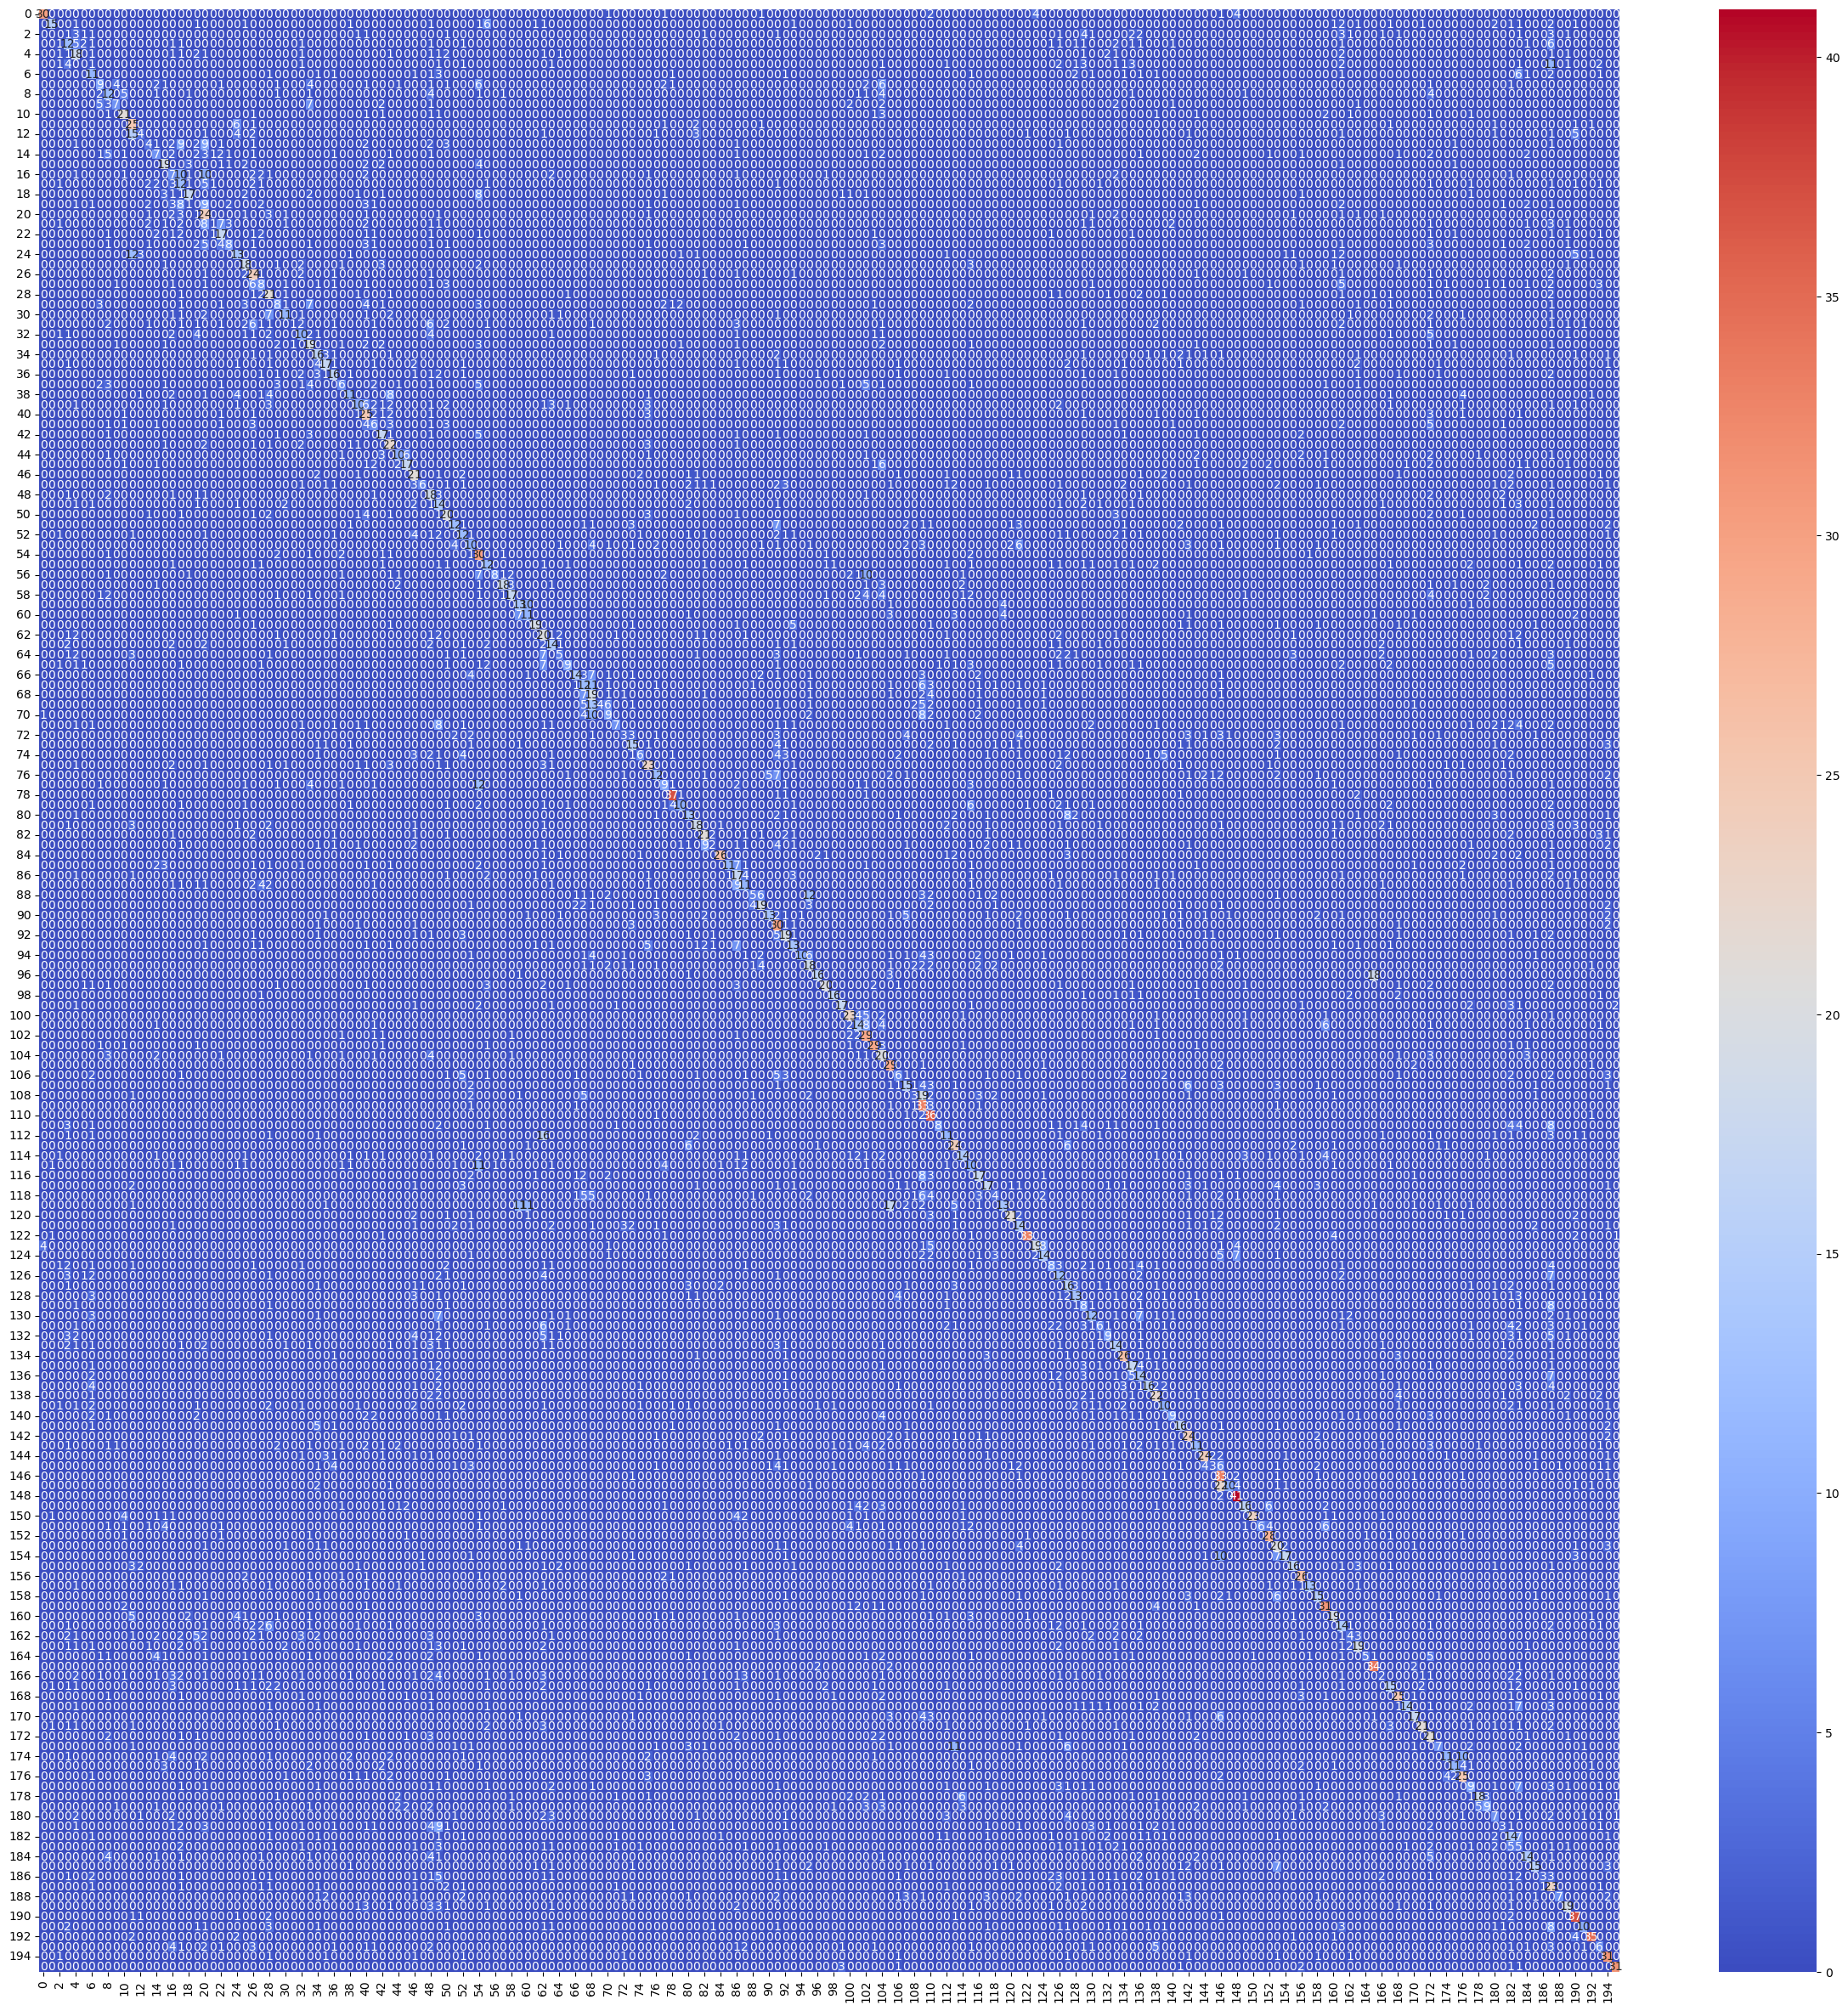

In [19]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm") 
plt.show()

In [20]:
# Flatten the confusion matrix DataFrame into a long format for filtering
cm_long = cm_df.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
cm_long = cm_long.rename(columns={'index': 'Actual'})

# Filter for misclassifications (Actual != Predicted) where the count is greater than 10
misclassified = cm_long[(cm_long['Actual'] != cm_long['Predicted']) & (cm_long['Count'] > 10)]

# Sort for better visibility
misclassified = misclassified.sort_values(by='Count', ascending=False)

# Display or save
logger.info(misclassified)

                                           Actual  \
28763                       Jeep Patriot SUV 2012   
21472                 Ford F-150 Regular Cab 2007   
32436               Dodge Sprinter Cargo Van 2009   
20699                         GMC Savana Van 2012   
12264                       Ford Focus Sedan 2007   
2168                          Audi 100 Wagon 1994   
13397   Chevrolet Silverado 1500 Regular Cab 2012   
2180                           Audi V8 Sedan 1994   
10661         Chrysler Crossfire Convertible 2008   
18708                  Dodge Dakota Club Cab 2007   
10699               Ford Mustang Convertible 2007   
11683                         GMC Savana Van 2012   
11879                         GMC Savana Van 2012   
13395  Chevrolet Silverado 1500 Extended Cab 2012   
22321              Ram C_V Cargo Van Minivan 2012   
36657                        Acura TSX Sedan 2012   

                                           Predicted  Count  
28763                          Jeep 

In [21]:
logger.info(cr)

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.86      0.68      0.76        44
                             Acura Integra Type R 2001       0.75      0.34      0.47        44
                                   Acura RL Sedan 2012       0.00      0.00      0.00        32
                                   Acura TL Sedan 2012       0.23      0.28      0.25        43
                                  Acura TL Type-S 2008       0.31      0.43      0.36        42
                                  Acura TSX Sedan 2012       0.00      0.00      0.00        40
                              Acura ZDX Hatchback 2012       0.21      0.28      0.24        39
              Aston Martin V8 Vantage Convertible 2012       0.33      0.20      0.25        45
                    Aston Martin V8 Vantage Coupe 2012       0.23      0.29      0.26        41
                  Aston Martin Virage C